This program utilizes the Oxford Parkinsons' Disease Detection Dataset from the UC Irvine Machine Learning Repository.

Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The One-Class Support Vector Machine (One-Class SVM) was chosen as the primary model for this analysis due to the nature of the dataset and the problem we're trying to solve. We want to identify subtle deviations in voice patterns that might indicate early or atypical onsets of the disease. One-Class SVM excels at identifying data points that are "different" from the majority of the training data, which could be crucial for early detection. While we train the One-Class SVM on primarily healthy samples, it's possible there might be some minor variations within that group. SVMs, in general, are robust to outliers, and the One-Class variant maintains that robustness, preventing a few slightly unusual healthy samples from drastically skewing the model. Additionally, One-Class SVM excels in handling imbalance which is a key component to why it outshines many other Machine Learning models.

In [2]:
data = np.load("parkinsons.npy", allow_pickle=True)
#Remove target column "status"
X = np.delete(data, 16, axis=1) 
y = data[:,16]
X_train = X[y == 0]

scaler = RobustScaler()
scaled_train_X = scaler.fit_transform(X_train)
scaled_X = scaler.transform(X)

In [3]:
#Parameter Tuning
nu_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gamma_vals = np.logspace(-1, 3, num = 30)
param_grid = {'nu': nu_vals, 'gamma': gamma_vals}
vals = []

#Grid search to find the best nu and gamma values
for params in ParameterGrid(param_grid):
        ocsvm = OneClassSVM(kernel = 'rbf', nu = params['nu'], gamma = params['gamma'])
        ocsvm.fit(scaled_train_X)

        predictions = ocsvm.predict(scaled_X)
        predictions = np.where(predictions == 1, 0, 1)

        #score evaluation
        tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / len(y)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        vals.append({
            'nu': params['nu'],
            'gamma': params['gamma'],
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp, 
            'True Negatives': tn
        })

results = pd.DataFrame(vals)
best_results = results.sort_values(by='F1 Score', ascending = False).iloc[0]      

print("Best Results: ")
print(best_results)

Best Results: 
nu                   0.500000
gamma               22.122163
Precision            0.948387
Recall               1.000000
Accuracy             0.958974
F1 Score             0.973510
False Positives      8.000000
False Negatives      0.000000
True Positives     147.000000
True Negatives      40.000000
Name: 157, dtype: float64


In [4]:
ocsvm = OneClassSVM(kernel = 'rbf', nu = best_results[0], gamma = best_results[1])
ocsvm.fit(scaled_train_X)
predictions  = ocsvm.predict(scaled_X)

labels = np.where(predictions == 1, 0, 1)

print(f"Parkinsons: {np.count_nonzero(y == 0)}")
print(f"Healthy: {np.count_nonzero(y == 1)}")

report = classification_report(y, labels, target_names=['Healthy', 'Parkinsons'])
print(report)

Parkinsons: 48
Healthy: 147
              precision    recall  f1-score   support

     Healthy       1.00      0.83      0.91        48
  Parkinsons       0.95      1.00      0.97       147

    accuracy                           0.96       195
   macro avg       0.97      0.92      0.94       195
weighted avg       0.96      0.96      0.96       195



C:\Users\Subh\AppData\Local\Temp\ipykernel_14680\3005895395.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ocsvm = OneClassSVM(kernel = 'rbf', nu = best_results[0], gamma = best_results[1])


Implemented a ROC Curve to visualize true positives vs false positives in different scenarios and demonstrate how well the model is able to distinguish between the two classes.

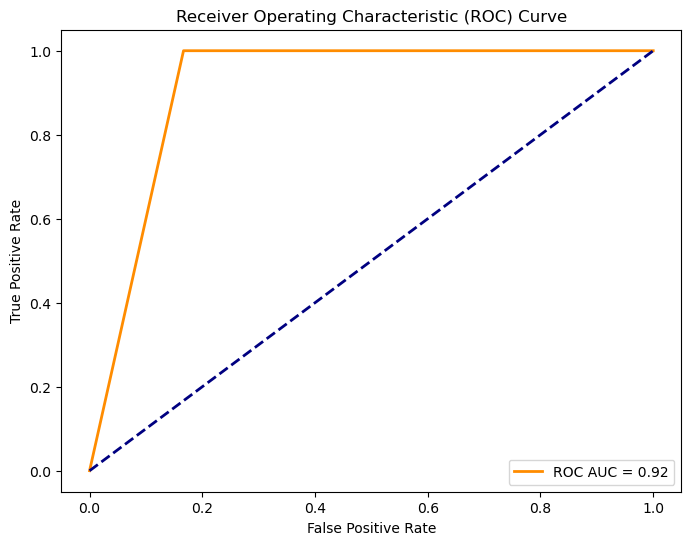

In [5]:
fpr, tpr, thresholds_roc = roc_curve(y, labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

We can see by visualizing the area under the precision-recall curve that this model performs excellently in disntingujishing between positive and negative instances in the data while there is an imbalance between the two classes.

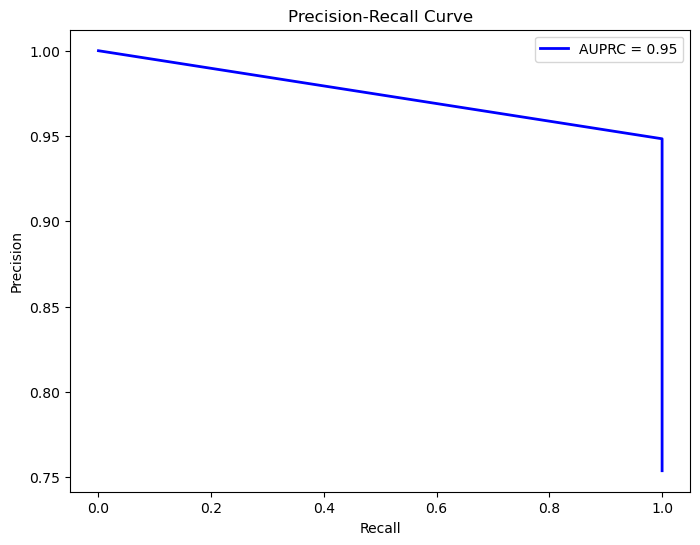

In [6]:
precision, recall, thresholds_pr = precision_recall_curve(y, labels)
auprc = average_precision_score(y, labels)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'AUPRC = {auprc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [7]:
misclassified_idx = np.where(y != labels)[0]
print(f"\nThere are {misclassified_idx.size} misclassified samples. These are their indices:",misclassified_idx)


There are 8 misclassified samples. These are their indices: [ 31  33  46 174 175 190 191 192]


Below are two plots, one which represents the original data samples and the other which represents all predicted data points. In order to achieve a cleaner visualization, PCA was implemented to condense the dataset's features down to only 2. It is very clear that model succeeded in accurately classifying  healthy and Parkinson's data samples.

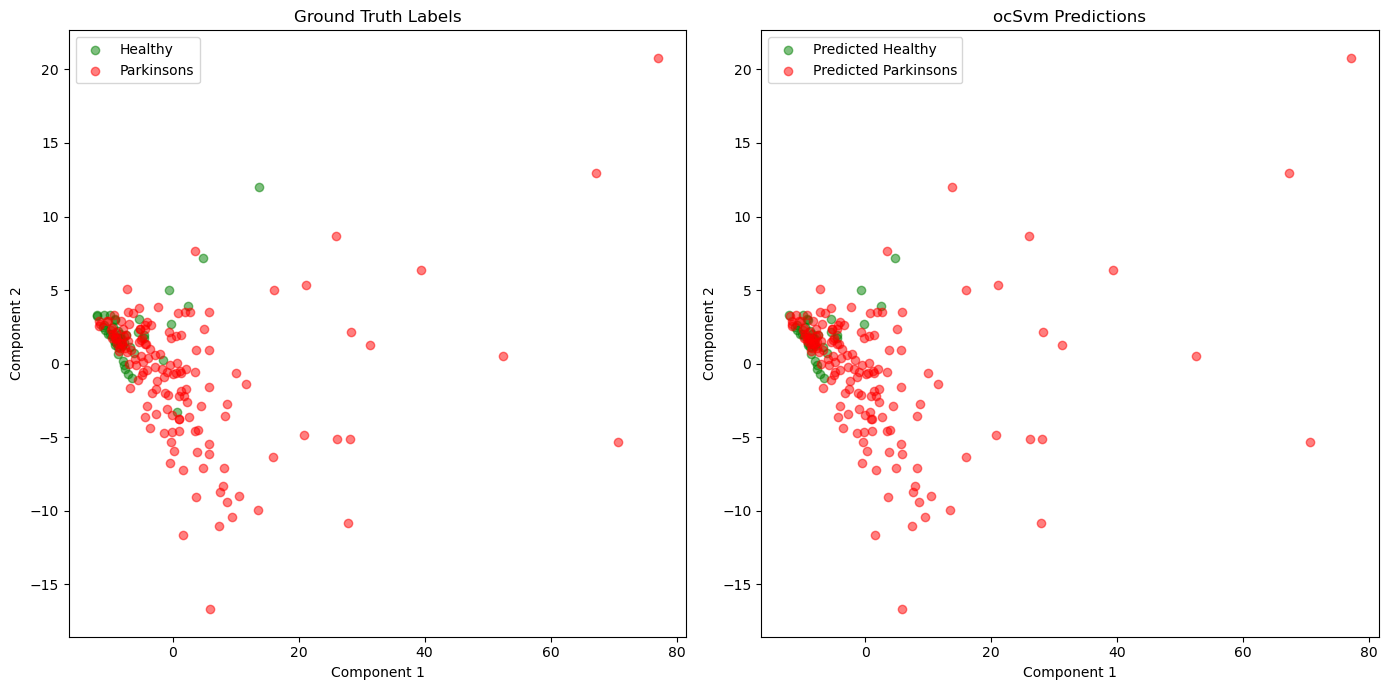

In [8]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(scaled_X)

plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.title("Ground Truth Labels")
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='green', label = 'Healthy', alpha = 0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', label = 'Parkinsons', alpha = 0.5)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("ocSvm Predictions")
plt.scatter(X_pca[predictions == 1, 0], X_pca[predictions == 1, 1], color='green', label = 'Predicted Healthy', alpha = 0.5)
plt.scatter(X_pca[predictions == -1, 0], X_pca[predictions == -1, 1], color='red', label = 'Predicted Parkinsons', alpha = 0.5)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()

plt.tight_layout()
plt.show()